<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the CA data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [521]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [522]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [523]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [524]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv		     CA_sd_inertia_labeledData_Sep25.csv
CA_combined_Sep25.csv		     CA_socialDistancingInertiaData_Sep09.csv
CA-CovidAug22.csv		     CA_socialDistancingInertiaData_Sep25.csv
CA_labeledData_Sep09		     Maryland_University_SocialDistancing_Data
CA_labeledData_Sep18.csv	     mask_rule.csv
CA_labeledData_Sep20.csv	     Newyork_combinedAug22.csv
CA_labeledData_Sep22.csv	     NY_sd_inertia_labeledData_Aug26.csv
CA_labeledData_Sep25.csv	     NY_socialDistancingInertiaDataAug25.csv
CA_sd_inertia_labeledData_Sep09      Social_Distancing_Inertia_County.csv
CA_sd_inertia_labeledData_Sep18.csv  TX_combined_Sep10.csv
CA_sd_inertia_labeledData_Sep20.csv  TX-Covid_Sep10.csv
CA_sd_inertia_labeledData_Sep22.csv  TX_socialDistancingInertiaData_Sep10.csv


# 1.1 Loading CA data

In [525]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_combined_Sep25.csv',low_memory=False)
CA_combined_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0


## Computing rolling average

In [526]:
CA_combined_data.iloc[:,15]

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
9191    0.669
9192    0.669
9193    0.669
9194    0.669
9195    0.669
Name: mask_wearing_percent, Length: 9196, dtype: float64

In [527]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [528]:
CA_counties = CA_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = CA_combined_data[CA_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN,1671329.0


In [529]:
print(df.shape)
CA_combined_data.shape

(9196, 18)


(9196, 17)

In [530]:
CA_combined_data = df.copy()
CA_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,NaN,1671329.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2020-08-17,6115,Yuba County,0.0,0.0,0.0,0.0,-34.0,7.0,64.29,4.100,43,124.506204,1,0.669,0,0.669,78668.0
9192,2020-08-18,6115,Yuba County,0.0,0.0,0.0,0.0,-32.0,8.0,54.39,4.944,52,124.506204,1,0.669,28,0.669,78668.0
9193,2020-08-19,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,8.0,61.72,4.090,43,124.506204,1,0.669,35,0.669,78668.0
9194,2020-08-20,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,0.669,78668.0


In [531]:
CA_combined_data[CA_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
151,2020-08-01,6001,Alameda County,-44.0,-13.0,28.0,-49.0,-19.0,9.0,9.45,1.041,16,2261.547725,1,0.795,345,0.795,1671329.0
323,2020-08-01,6005,Amador County,-9.0,12.0,0.0,0.0,-15.0,0.0,123.25,2.433,18,66.857277,1,0.655,10,0.655,39752.0
495,2020-08-01,6007,Butte County,-21.0,2.0,39.0,0.0,-15.0,3.0,55.33,2.452,53,133.939112,1,0.626,0,0.626,219186.0
667,2020-08-01,6009,Calaveras County,-31.0,0.0,0.0,0.0,-10.0,0.0,154.27,5.737,33,45.004461,1,0.562,0,0.562,45905.0
839,2020-08-01,6011,Colusa County,-14.0,0.0,0.0,-18.0,-5.0,0.0,138.38,10.870,75,18.724636,1,0.700,0,0.700,21547.0
1011,2020-08-01,6013,Contra Costa County,-34.0,-3.0,24.0,-33.0,-21.0,7.0,25.51,1.790,23,1611.204850,1,0.806,136,0.806,1153526.0
1183,2020-08-01,6015,Del Norte County,32.0,48.0,0.0,0.0,-3.0,0.0,388.59,2.082,92,27.635959,1,0.547,0,0.547,27812.0
1355,2020-08-01,6017,El Dorado County,-13.0,9.0,161.0,3.0,-17.0,4.0,174.95,4.362,44,112.913671,1,0.675,0,0.675,192843.0
1527,2020-08-01,6019,Fresno County,-24.0,0.0,30.0,-16.0,-15.0,4.0,47.48,1.743,26,167.690949,1,0.741,0,0.741,999101.0
1699,2020-08-01,6021,Glenn County,-13.0,5.0,0.0,26.0,-15.0,0.0,135.39,5.116,35,21.608889,1,0.594,0,0.594,28393.0


In [532]:
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN,1671329.0
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,NaN,1671329.0
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.0,1671329.0
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.0,1671329.0


## clean data - fill NA 

In [533]:
CA_combined_data = CA_combined_data.fillna(0)
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.0,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.0,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.0,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.0,1671329.0
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,0.0,1671329.0
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.0,1671329.0
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.0,1671329.0


In [534]:
CA_combined_data['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

## verifying Rolling average with visualizations -Los Angeles County

In [535]:
los_angeles_county = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

(172, 18)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,10039107.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,10039107.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0,10039107.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0,10039107.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0,10039107.0


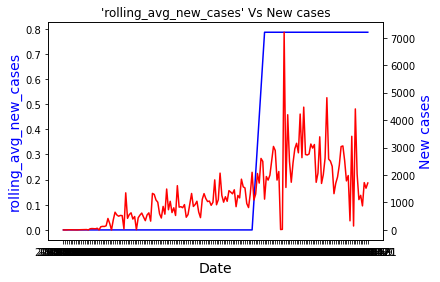

In [536]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [537]:
suffolk_county = CA_combined_data[CA_combined_data['County Name'] == 'Santa Clara County']

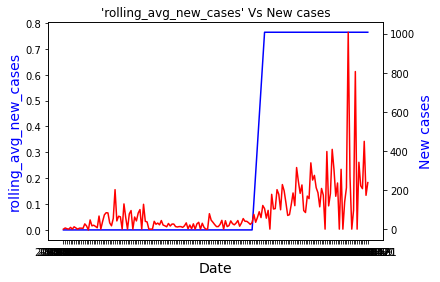

In [538]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [539]:
CA_combined_data = CA_combined_data.sort_values(by=['Date'])
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0


In [540]:
CA_combined_data[CA_combined_data['fips_x'] == 6037]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.000,0,0.000,10039107.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.000,0,0.000,10039107.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.000,0,0.000,10039107.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.000,6,0.000,10039107.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.000,4,0.000,10039107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2020-08-17,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,13.0,1.14,1.472,22,2473.978284,1,0.786,1259,0.786,10039107.0
3092,2020-08-18,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,3.51,2.137,32,2473.978284,1,0.786,875,0.786,10039107.0
3093,2020-08-19,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,6.42,1.656,25,2473.978284,1,0.786,1722,0.786,10039107.0
3094,2020-08-20,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,8.13,2.227,33,2473.978284,1,0.786,1519,0.786,10039107.0


In [541]:
minDate = CA_combined_data['Date'].min()
print(minDate)

dateList = CA_combined_data['Date'].unique()

2020-03-01


In [542]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [543]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']


In [544]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head()

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28
2,3,2020-03-29,2020-04-11
3,4,2020-04-12,2020-04-26
4,5,2020-04-27,2020-05-10


## Slice data for the week dataframe

In [545]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [546]:
average_newCases_df.shape

(701, 5)

In [547]:
average_newCases_df[average_newCases_df['fips_x'] == 6037]

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14
17,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28
17,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11
17,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26
17,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10
17,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24
17,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08
17,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22
17,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06
17,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [548]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



2924    0.0
2925    0.0
2926    0.0
2927    0.0
2928    0.0
2929    0.0
2930    0.0
2931    0.0
2932    0.0
2933    0.0
2934    0.0
2935    0.0
2936    0.0
2937    0.0
Name: rolling_avg_new_cases, dtype: float64

In [549]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14
5,Contra Costa County,6013,0.0,2020-03-01,2020-03-14
6,Del Norte County,6015,0.0,2020-03-01,2020-03-14
7,El Dorado County,6017,0.0,2020-03-01,2020-03-14
8,Fresno County,6019,0.0,2020-03-01,2020-03-14
9,Glenn County,6021,0.0,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [550]:
average_newCases_df_ = average_newCases_df.copy()

In [551]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Los Angeles County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14
17,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28
17,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11
17,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26
17,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10
17,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24
17,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08
17,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22
17,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06
17,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20


In [552]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [553]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14


In [554]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [555]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14


In [556]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(701, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [557]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Santa Clara County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
40,Santa Clara County,6085,0.000000,2020-03-01,2020-03-14,0.000000e+00
94,Santa Clara County,6085,0.000000,2020-03-15,2020-03-28,0.000000e+00
147,Santa Clara County,6085,0.000000,2020-03-29,2020-04-11,0.000000e+00
201,Santa Clara County,6085,0.000000,2020-04-12,2020-04-26,0.000000e+00
255,Santa Clara County,6085,0.000000,2020-04-27,2020-05-10,0.000000e+00
309,Santa Clara County,6085,0.000000,2020-05-11,2020-05-24,0.000000e+00
363,Santa Clara County,6085,0.000000,2020-05-25,2020-06-08,0.000000e+00
417,Santa Clara County,6085,0.116939,2020-06-09,2020-06-22,1.169388e-01
471,Santa Clara County,6085,0.756204,2020-06-23,2020-07-06,6.392653e-01
525,Santa Clara County,6085,0.764000,2020-07-07,2020-07-20,7.795918e-03


In [558]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Alameda County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.000000,2020-03-01,2020-03-14,0.000000
54,Alameda County,6001,0.000000,2020-03-15,2020-03-28,0.000000
108,Alameda County,6001,0.000000,2020-03-29,2020-04-11,0.000000
161,Alameda County,6001,0.000000,2020-04-12,2020-04-26,0.000000
215,Alameda County,6001,0.000000,2020-04-27,2020-05-10,0.000000
269,Alameda County,6001,0.000000,2020-05-11,2020-05-24,0.000000
323,Alameda County,6001,0.000000,2020-05-25,2020-06-08,0.000000
377,Alameda County,6001,0.121684,2020-06-09,2020-06-22,0.121684
431,Alameda County,6001,0.786888,2020-06-23,2020-07-06,0.665204
485,Alameda County,6001,0.795000,2020-07-07,2020-07-20,0.008112


In [559]:
average_newCases_df2[average_newCases_df2['fips_x'] == 6037].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
17,Los Angeles County,6037,0.0,2020-03-01,2020-03-14,0.0
71,Los Angeles County,6037,0.0,2020-03-15,2020-03-28,0.0
125,Los Angeles County,6037,0.0,2020-03-29,2020-04-11,0.0
178,Los Angeles County,6037,0.0,2020-04-12,2020-04-26,0.0
232,Los Angeles County,6037,0.0,2020-04-27,2020-05-10,0.0


In [560]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [561]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [562]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [563]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [564]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [565]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name    fips_x startDate  endDate                       ...             
Alameda County 6001   2020-03-01 2020-03-14          0.000000  ...     0.000000
                      2020-03-15 2020-03-28          0.000000  ...     0.000000
                      2020-03-29 2020-04-11          0.000000  ...     0.000000
                      2020-04-12 2020-04-26          0.000000  ...     0.000000
                      2020-04-27 2020-05-10          0.000000  ...     0.000000
...                                                       ...  ...          ...
Yuba County    6115   2020-06-23 2020-07-06          0.662173  ...     0.102398
                      2020-07-07 2020-07-20          0.669000  ...     0.662173
                      2020-07-21 2020-08-03          0.669000  ...     0.669000
                      2020-08-04 2020-08-17          0.669000  ...     0.669000
                      2020-08-18 2020-08-21          0.669000  ...     0.669000

[701 rows x 3 columns]

In [566]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14,0.000000e+00,NaN
71,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28,0.000000e+00,0.000000
125,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11,0.000000e+00,0.000000
178,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26,0.000000e+00,0.000000
232,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10,0.000000e+00,0.000000
286,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24,0.000000e+00,0.000000
340,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08,0.000000e+00,0.000000
394,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22,1.203061e-01,0.000000
448,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06,6.576735e-01,0.120306
502,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20,8.020408e-03,0.777980


In [567]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
696,Tulare County,6107,0.685,2020-08-18,2020-08-21,1.110223e-16,0.685,1.620764e-16
697,Tuolumne County,6109,0.653,2020-08-18,2020-08-21,1.110223e-16,0.653,1.700188e-16
698,Ventura County,6111,0.777,2020-08-18,2020-08-21,1.110223e-16,0.777,1.428858e-16
699,Yolo County,6113,0.791,2020-08-18,2020-08-21,0.000000e+00,0.791,0.000000e+00
700,Yuba County,6115,0.669,2020-08-18,2020-08-21,1.110223e-16,0.669,1.659526e-16


In [568]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14,0.000000e+00,NaN,0.000000e+00
71,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28,0.000000e+00,0.000000,0.000000e+00
125,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11,0.000000e+00,0.000000,0.000000e+00
178,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26,0.000000e+00,0.000000,0.000000e+00
232,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10,0.000000e+00,0.000000,0.000000e+00
286,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24,0.000000e+00,0.000000,0.000000e+00
340,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08,0.000000e+00,0.000000,0.000000e+00
394,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22,1.203061e-01,0.000000,0.000000e+00
448,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06,6.576735e-01,0.120306,5.466667e+00
502,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20,8.020408e-03,0.777980,1.030928e-02


# 1.2 Labeling data as per % change

## Validation

In [569]:
test_ca_combined = average_newCases_df2.copy()

In [570]:
test_ca_combined[(test_ca_combined['fips_x']== 6001) & (test_ca_combined['startDate']=='2020-08-18')]

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
647,Alameda County,6001,0.795,2020-08-18,2020-08-21,0.0,0.795,0.0


## Actual Work

In [571]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,701.000000,701.000000,7.010000e+02,647.000000,7.010000e+02
mean,6057.724679,0.286073,5.565335e-02,0.249651,4.295390e-01
std,32.987094,0.350164,1.627743e-01,0.338997,1.497501e+00
min,6001.000000,0.000000,-2.220446e-16,0.000000,-2.523234e-16
25%,6029.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,6059.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
75%,6085.000000,0.685000,1.110223e-16,0.669000,0.000000e+00
max,6115.000000,0.889000,7.438571e-01,0.889000,1.073333e+01


In [572]:
los_angeles_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

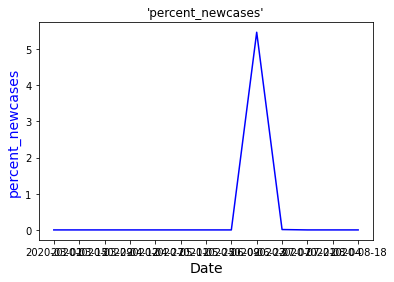

In [573]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [574]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [575]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [576]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


In [577]:
new_cases_list = average_newCases_df2['percent_newcases'].values

## Determining growth label for covid cases

#### Getting diff array

In [578]:
len(new_cases_list)

701

In [579]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

700


0.0

In [580]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))


growth_values :  1
growth_values :  701


In [581]:
len(growth_values)

701

In [582]:
average_newCases_df2['growth_per_day'] = growth_values

In [583]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [584]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -5.456357388316149
max  5.466666666666666
mean  4.336808689942018e-19
std. deviation  0.4055787169294746
variance  0.16449409562615888


#### Getting positive cases

In [585]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

length diffArr:  700
non_zero_pos_diff length:  77


In [586]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  3.537345784081112e-18
max  5.466666666666666
mean  0.14047758512964761
std. deviation  0.8536375206133405
variance  0.7286970165988914


#### Getting negative cases

In [587]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  700
non_zero_neg_diff length :  72


In [588]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -5.456357388316149
max  -6.938893903907228e-18
mean  -0.15023297298587315
std. deviation  0.8810634848931068
variance  0.7762728644119858


### Trying natural breaks

In [589]:
!pip install jenkspy


In [590]:
import jenkspy

In [591]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[3.537345784081112e-18, 0.08344072164948449, 5.466666666666666]
[-5.456357388316149, -5.26666666666667, -6.938893903907228e-18]


##### **Note**: 
From the positive and negative break, 
* [ -0.012359, 0.000374 ] - flat growth
* [ 0.000374, 21.813186 ] - mild growth
* [ 21.813186, 95.421053 ] - drastic growth
* [ -0.012359, -21.813186 ] - mild decrement
* [ -21.813186, -95.421053 ] - drastic decrement

In [592]:
# original range for CA combined data

'''
def determine_growth_label(x):
  if x >= -0.012359 and x <= 0.000374:
    return 'flat_growth'
  if x > 0.000374 and x <= 21.813186:
    return 'mild_growth'
  if x > 21.813186 and x <= 95.421053:
    return 'drastic_growth'
  if x >= -21.813186  and x <= -0.012359:
    return 'mild_decrement'
  if x >= -95.421053 and x < -21.813186:
    return 'drastic_decrement'
'''


"\ndef determine_growth_label(x):\n  if x >= -0.012359 and x <= 0.000374:\n    return 'flat_growth'\n  if x > 0.000374 and x <= 21.813186:\n    return 'mild_growth'\n  if x > 21.813186 and x <= 95.421053:\n    return 'drastic_growth'\n  if x >= -21.813186  and x <= -0.012359:\n    return 'mild_decrement'\n  if x >= -95.421053 and x < -21.813186:\n    return 'drastic_decrement'\n"

In [593]:
# temporarily using NY combined data range for CA
def determine_growth_label(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [594]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [595]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


In [596]:
average_newCases_df2_growth0 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_decrement']
average_newCases_df2_growth1 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_growth']
average_newCases_df2_growth2 = average_newCases_df2[average_newCases_df2['growth_label'] == 'flat_growth']
average_newCases_df2_growth3 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_decrement']
average_newCases_df2_growth4 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_growth']

print(average_newCases_df2_growth0.shape)
print(average_newCases_df2_growth1.shape)
print(average_newCases_df2_growth2.shape)
print(average_newCases_df2_growth3.shape)
print(average_newCases_df2_growth4.shape)

(0, 10)
(0, 10)
(694, 10)
(4, 10)
(3, 10)


## Jenks Natural breaks 

In [597]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.523234146875355e-16, 0.09375000000000003, 5.4666666666666694, 10.733333333333338]


In [598]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.523234146875355e-16, 2.754895842742325e-16, 0.010309278350515535, 0.010309278350515542, 0.01030927835051564, 0.09375000000000003, 5.466666666666665, 5.4666666666666694, 10.733333333333338]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [599]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [600]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 592
Number of records in Spread: 43
Number of records in SuperSpread: 2
Number of records in SuperSpread2: 8
Number of records in SuperSpread3: 1
Number of records in SuperSpread4: 14
Number of records in SuperSpread5: 39
Number of records in SuperSpread6: 1


In [601]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.523234146875355e-16, 0.01030927835051564, 0.09375000000000003, 5.4666666666666694, 10.733333333333338]


In [602]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [603]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 645
Number of records in Spread: 1
Number of records in SuperSpread: 53
Number of records in SuperSpread: 1


In [604]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 1.3 Labeling data for CA combined

In [605]:
CA_combined_data.head(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0


In [606]:
CA_combined_data_ = CA_combined_data.copy()

In [607]:
CA_combined_data = CA_combined_data_.copy().reset_index(drop=True)

In [608]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_data['fips_x'] == row['fips_x']) & (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    #print(df_weekData)
    CA_combined_data.loc[df_index,'label'] = row['labels']
    CA_combined_data.loc[df_index,'growth_label'] = row['growth_label']




In [609]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0,LessSpread,flat_growth


In [610]:
CA_combined_data[CA_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     10
fips_x                   10
County Name              10
retail and recreation    10
grocery and pharmacy     10
parks                    10
transit stations         10
workplaces               10
residential              10
driving                  10
m50                      10
m50_index                10
population_density       10
mask_rule_active         10
mask_wearing_percent     10
New cases                10
rolling_avg_new_cases    10
population               10
label                    10
growth_label             10
dtype: int64

In [611]:
CA_combined_data.shape

(9196, 20)

In [612]:
CA_combined_data['label'] = CA_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

In [613]:
CA_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
population               float64
label                     object
growth_label              object
dtype: object

In [614]:
CA_combined_data[CA_combined_data['label'] == 'LessSpread'].count()

Date                     8429
fips_x                   8429
County Name              8429
retail and recreation    8429
grocery and pharmacy     8429
parks                    8429
transit stations         8429
workplaces               8429
residential              8429
driving                  8429
m50                      8429
m50_index                8429
population_density       8429
mask_rule_active         8429
mask_wearing_percent     8429
New cases                8429
rolling_avg_new_cases    8429
population               8429
label                    8429
growth_label             8429
dtype: int64

In [615]:
CA_combined_data[CA_combined_data['growth_label'] == 'flat_growth'].count()

Date                     9105
fips_x                   9105
County Name              9105
retail and recreation    9105
grocery and pharmacy     9105
parks                    9105
transit stations         9105
workplaces               9105
residential              9105
driving                  9105
m50                      9105
m50_index                9105
population_density       9105
mask_rule_active         9105
mask_wearing_percent     9105
New cases                9105
rolling_avg_new_cases    9105
population               9105
label                    9101
growth_label             9105
dtype: int64

## Computing New Cases per 1k Population

Formula: 'New Cases/1k population' = (New Cases * 1000)/population

In [616]:
CA_combined_data['New Cases/1k population'] = CA_combined_data['New cases']*1000/ CA_combined_data['population']
CA_combined_data.tail(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population
9194,2020-08-21,6035,Lassen County,0.0,0.0,0.0,0.0,-24.0,0.0,222.10,3.061,100,6.732391,1,0.482,0,0.482,30573.0,LessSpread,flat_growth,0.000000
9195,2020-08-21,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,10.0,84.31,5.820,61,124.506204,1,0.669,8,0.669,78668.0,LessSpread,flat_growth,0.101693


In [617]:
new_cases_10k_list = CA_combined_data['New Cases/1k population'].values

In [618]:
diffArr = np.diff(new_cases_10k_list)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

9195
growth_values :  1
growth_values :  9196


In [619]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -3.8230281887128026
max  3.960127989407119
mean  1.1059618449245788e-05
std. deviation  0.24857264730595022
variance  0.061788360988688326


## Getting positive cases

In [620]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

length diffArr:  9195
non_zero_pos_diff length:  3594
min  5.2680092775606036e-05
max  3.960127989407119
mean  0.12711974477163043
std. deviation  0.25049541298583716
variance  0.06274795192694511


## Getting negative cases


In [621]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


non_zero_neg_diff length :  3583
min  -3.8230281887128026
max  -8.310897482368892e-06
mean  -0.12748162699346885
std. deviation  0.2513272017941629
variance  0.0631653623616839


In [622]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0,LessSpread,flat_growth,0.0


## Applying natural breaks

In [623]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]


## New Labeling

In [624]:
'''
[9.99999999999994e-05, 0.3248, 2.1234]
[-2.1359000000000004, -0.34040000000000004, -9.999999999998899e-05]
def determine_growth_label_inertia1k(x):
  if x >= -0.000009 and x <= 0.00009:
    return 'flat_growth'
  if x > 0.00009 and x <= 0.3248:
    return 'mild_growth'
  if x > 0.3248 and x <= 2.1234:
    return 'drastic_growth'
  if x >= -0.3404  and x <= -0.000009:
    return 'mild_decrement'
  if x >= -2.1359 and x < -0.3404:
    return 'drastic_decrement'
'''

"\n[9.99999999999994e-05, 0.3248, 2.1234]\n[-2.1359000000000004, -0.34040000000000004, -9.999999999998899e-05]\ndef determine_growth_label_inertia1k(x):\n  if x >= -0.000009 and x <= 0.00009:\n    return 'flat_growth'\n  if x > 0.00009 and x <= 0.3248:\n    return 'mild_growth'\n  if x > 0.3248 and x <= 2.1234:\n    return 'drastic_growth'\n  if x >= -0.3404  and x <= -0.000009:\n    return 'mild_decrement'\n  if x >= -2.1359 and x < -0.3404:\n    return 'drastic_decrement'\n"

In [625]:
[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]
def determine_growth_label_1k(x):
  if x >= -0.00000831 and x <= 0.0000526:
    return 'flat_growth'
  if x > 0.0000526 and x <= 0.59285:
    return 'mild_growth'
  if x > 0.59285 and x <= 3.96013:
    return 'drastic_growth'
  if x >= -0.56595  and x <= -0.00000831:
    return 'mild_decrement'
  if x >= -3.96013 and x < -0.56595:
    return 'drastic_decrement'

In [626]:
CA_combined_data['growth_label_1k'] = CA_combined_data['New Cases/1k population'].apply(lambda x: determine_growth_label_1k(x) )
CA_combined_data.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0,flat_growth


### Export Combined labeled Data

In [627]:
CA_combined_data_growth0 = CA_combined_data[CA_combined_data['growth_label'] == 'drastic_decrement']
CA_combined_data_growth1 = CA_combined_data[CA_combined_data['growth_label'] == 'drastic_growth']
CA_combined_data_growth2 = CA_combined_data[CA_combined_data['growth_label'] == 'flat_growth']
CA_combined_data_growth3 = CA_combined_data[CA_combined_data['growth_label'] == 'mild_decrement']
CA_combined_data_growth4 = CA_combined_data[CA_combined_data['growth_label'] == 'mild_growth']

print(CA_combined_data_growth0.shape)
print(CA_combined_data_growth1.shape)
print(CA_combined_data_growth2.shape)
print(CA_combined_data_growth3.shape)
print(CA_combined_data_growth4.shape)

(0, 22)
(0, 22)
(9105, 22)
(56, 22)
(35, 22)


In [628]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_data.to_csv(location+filename,index=False)

CA_labeledData_Sep25.csv


In [629]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
431,Alameda County,6001,0.786888,2020-06-23,2020-07-06,0.665204,0.121684,5.466667,5.466667e+00,mild_growth,SuperSpread
432,Amador County,6005,0.648316,2020-06-23,2020-07-06,0.548061,0.100255,5.466667,1.776357e-15,flat_growth,SuperSpread
433,Butte County,6007,0.619612,2020-06-23,2020-07-06,0.523796,0.095816,5.466667,-8.881784e-16,flat_growth,SuperSpread
434,Calaveras County,6009,0.556265,2020-06-23,2020-07-06,0.470245,0.086020,5.466667,1.776357e-15,flat_growth,SuperSpread
435,Colusa County,6011,0.692857,2020-06-23,2020-07-06,0.585714,0.107143,5.466667,-8.881784e-16,flat_growth,SuperSpread
436,Contra Costa County,6013,0.797776,2020-06-23,2020-07-06,0.674408,0.123367,5.466667,-1.776357e-15,flat_growth,SuperSpread
437,Del Norte County,6015,0.541418,2020-06-23,2020-07-06,0.457694,0.083724,5.466667,-8.881784e-16,flat_growth,SuperSpread
438,El Dorado County,6017,0.668112,2020-06-23,2020-07-06,0.564796,0.103316,5.466667,8.881784e-16,flat_growth,SuperSpread
439,Fresno County,6019,0.733439,2020-06-23,2020-07-06,0.620020,0.113418,5.466667,-8.881784e-16,flat_growth,SuperSpread
440,Glenn County,6021,0.587939,2020-06-23,2020-07-06,0.497020,0.090918,5.466667,2.664535e-15,flat_growth,SuperSpread


## Kernal Density Estimation

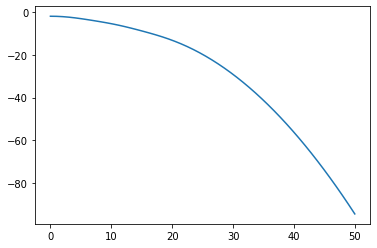

In [409]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [410]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: []
Maxima: []


In [411]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

IndexError: ignored

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [412]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


# 2.1 Loading CA - Social Distancing Inertia Maryland Data

In [413]:
CA_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_socialDistancingInertiaData_Sep25.csv',low_memory=False)
CA_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,2020-01-22,California,6001,0,0,0,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
1,2020-01-23,California,6001,0,0,0,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
2,2020-01-24,California,6001,0,0,0,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0
3,2020-01-25,California,6001,0,0,0,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,1,54.0,0.0,0.0,0.0,0,0
4,2020-01-26,California,6001,0,0,0,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,0,1.1,3.9,5.7,0.3,0.0,0.0,0.0,2,54.0,0.0,0.0,0.0,0,0


In [414]:
CA_combined_sd_inertia_data.FIPS.unique()

array([6001, 6003, 6005, 6007, 6009, 6011, 6013, 6015, 6017, 6019, 6021,
       6023, 6025, 6027, 6029, 6031, 6033, 6035, 6037, 6039, 6041, 6043,
       6045, 6047, 6049, 6051, 6053, 6055, 6057, 6059, 6061, 6063, 6065,
       6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087,
       6089, 6091, 6093, 6095, 6097, 6099, 6101, 6103, 6105, 6107, 6109,
       6111, 6113, 6115])

## Computing rolling average

In [415]:
CA_combined_sd_inertia_data.columns

Index(['Date', 'Province_State', 'FIPS', 'Confirmed', 'Deaths', 'New cases',
       'New deaths', 'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation

In [416]:
#new case column nume = 5
CA_combined_sd_inertia_data.iloc[:,5]

0         0
1         0
2         0
3         0
4         0
         ..
12291    18
12292     0
12293    28
12294    35
12295     0
Name: New cases, Length: 12296, dtype: int64

removing comuns: 
'Confirmed', 'Deaths', 'New deaths','#days: decreasing ILI cases', '#days: decreasing COVID cases', 'New cases/1000 people', 'Imported COVID cases' ,'COVID death rate',  'Active cases/1000 people',

In [417]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])


In [418]:
CA_counties = CA_combined_sd_inertia_data['CTNAME'].unique()

for county in CA_counties:
  county_data = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
4,2020-01-26,California,6001,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.1,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN


In [419]:
print(df.shape)
CA_combined_sd_inertia_data.shape

(12296, 54)


(12296, 53)

In [420]:
CA_combined_sd_inertia_data = df.copy()
CA_combined_sd_inertia_data

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,NaN
4,2020-01-26,California,6001,0,0,6001,Alameda County,6,41,28,2.80,25.6,0.4,35.4,0.24,2.56,0,1666753,-9.3,2020-01-26,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.00,1.1,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2020-08-16,California,6115,18,1,6115,Yuba County,6,40,27,2.65,49.3,0.8,45.1,0.18,2.47,18,78041,-12.1,2020-08-16,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.731048,6.3,247.70,20.87,1294,758.0,4.0,0.0,140.0,0.58,0.2990,6.27,0.0,517.0,22.571429
12292,2020-08-17,California,6115,0,1,6115,Yuba County,6,37,23,2.66,47.5,0.5,42.0,0.32,2.34,0,78041,-16.7,2020-08-17,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.762511,6.3,251.13,20.77,1298,758.0,4.0,0.0,140.0,0.58,0.0769,6.22,1.0,479.0,16.000000
12293,2020-08-18,California,6115,28,1,6115,Yuba County,6,31,22,2.82,46.3,0.4,51.6,0.33,2.49,28,78041,-11.3,2020-08-18,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.788291,6.3,254.04,20.66,1301,786.0,4.0,0.0,140.0,0.58,0.1965,6.28,2.0,472.0,17.142857
12294,2020-08-19,California,6115,35,1,6115,Yuba County,6,31,23,3.11,41.7,0.3,43.5,0.34,2.77,35,78041,-1.4,2020-08-19,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,NaN,6,48.19,5.4,27.3,26.9,1.71,60.948422,6.3,256.36,20.20,1334,821.0,4.0,0.0,140.0,0.58,0.2691,6.23,3.0,470.0,20.428571


In [421]:
CA_combined_sd_inertia_data.head(3)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,NaN,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## clean data - fill NA 

In [422]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.fillna(0)
CA_combined_sd_inertia_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,California,6001,0,0,6001,Alameda County,6,15,19,3.36,29.6,0.3,35.4,0.56,2.80,0,1666753,-0.8,2020-01-23,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,California,6001,0,0,6001,Alameda County,6,15,19,3.48,29.0,0.3,39.1,0.53,2.94,0,1666753,4.1,2020-01-24,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,California,6001,0,0,6001,Alameda County,6,30,24,3.16,26.6,0.3,36.3,0.27,2.88,0,1666753,2.0,2020-01-25,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [423]:
CA_combined_sd_inertia_data['CTNAME'].unique()

array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
       'Napa County', 'Nevada County', 'Orange County', 'Placer County',
       'Plumas County', 'Riverside County', 'Sacramento County',
       'San Benito County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Sierra County', 'Siskiyou County',
       'Solano 

## verifying Rolling average with visualizations

In [424]:
los_angeles_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

(212, 54)


,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3817,2020-01-23,California,6037,0,0,6037,Los Angeles County,6,15,19,3.43,10.9,0.4,34.7,0.63,2.80,0,10105518,1.2,2020-01-23,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3818,2020-01-24,California,6037,0,0,6037,Los Angeles County,6,14,18,3.53,11.1,0.4,37.4,0.60,2.93,0,10105518,5.9,2020-01-24,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3819,2020-01-25,California,6037,0,0,6037,Los Angeles County,6,25,22,3.24,11.8,0.4,34.6,0.31,2.93,0,10105518,5.9,2020-01-25,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3820,2020-01-26,California,6037,1,0,6037,Los Angeles County,6,37,27,2.83,11.5,0.5,33.5,0.26,2.57,1,10105518,-7.1,2020-01-26,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.1,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


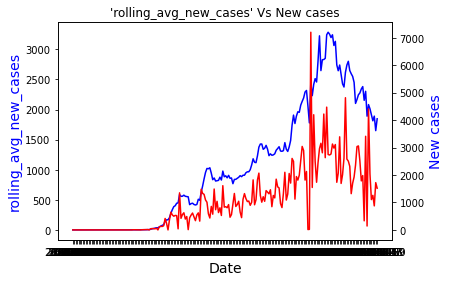

In [425]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [426]:
suffolk_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Santa Clara County']

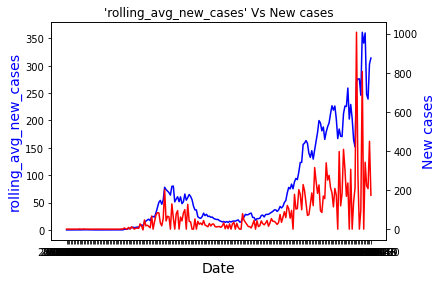

In [427]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [428]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.sort_values(by=['Date'])
CA_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4028,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10812,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['FIPS'] == 6037]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
3816,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3817,2020-01-23,California,6037,0,0,6037,Los Angeles County,6,15,19,3.43,10.9,0.4,34.7,0.63,2.80,0,10105518,1.2,2020-01-23,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3818,2020-01-24,California,6037,0,0,6037,Los Angeles County,6,14,18,3.53,11.1,0.4,37.4,0.60,2.93,0,10105518,5.9,2020-01-24,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3819,2020-01-25,California,6037,0,0,6037,Los Angeles County,6,25,22,3.24,11.8,0.4,34.6,0.31,2.93,0,10105518,5.9,2020-01-25,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.2,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,0.000000
3820,2020-01-26,California,6037,1,0,6037,Los Angeles County,6,37,27,2.83,11.5,0.5,33.5,0.26,2.57,1,10105518,-7.1,2020-01-26,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.00,1.1,3.9,5.7,0.30,54.000000,0.0,0.00,0.00,0,1.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,2020-08-16,California,6037,1104,1,6037,Los Angeles County,6,43,32,2.76,11.7,0.9,46.1,0.20,2.56,1104,10105518,-7.4,2020-08-16,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.731048,6.3,247.70,20.87,1294,221971.0,5254.0,8.0,140.0,0.58,0.2489,6.27,4.0,13295.0,1915.428571
4024,2020-08-17,California,6037,1259,1,6037,Los Angeles County,6,39,29,2.79,11.0,0.9,45.7,0.42,2.38,1259,10105518,-13.9,2020-08-17,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.762511,6.3,251.13,20.77,1298,223230.0,5273.0,19.0,140.0,0.58,0.1451,6.22,5.0,11997.0,1812.428571
4025,2020-08-18,California,6037,875,1,6037,Los Angeles County,6,37,28,2.86,11.0,0.8,44.7,0.43,2.43,875,10105518,-12.1,2020-08-18,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.788291,6.3,254.04,20.66,1301,224105.0,5340.0,67.0,140.0,0.58,0.1068,6.28,6.0,12288.0,1890.142857
4026,2020-08-19,California,6037,1722,1,6037,Los Angeles County,6,37,29,2.89,11.1,0.9,46.5,0.43,2.46,1722,10105518,-11.1,2020-08-19,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,48.19,5.4,27.3,26.9,1.71,60.948422,6.3,256.36,20.20,1334,225827.0,5392.0,52.0,140.0,0.58,0.1272,6.23,7.0,12491.0,1649.142857


In [430]:
minDate = CA_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = CA_combined_sd_inertia_data['Date'].unique()

2020-01-22


In [431]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [432]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-01-22', '2020-02-01']
[2, '2020-02-02', '2020-02-15']
[3, '2020-02-16', '2020-02-29']
[4, '2020-03-01', '2020-03-14']
[5, '2020-03-15', '2020-03-28']
[6, '2020-03-29', '2020-04-11']
[7, '2020-04-12', '2020-04-25']
[8, '2020-04-26', '2020-05-09']
[9, '2020-05-10', '2020-05-23']
[10, '2020-05-24', '2020-06-06']
[11, '2020-06-07', '2020-06-20']
[12, '2020-06-21', '2020-07-04']
[13, '2020-07-05', '2020-07-18']
[14, '2020-07-19', '2020-08-01']
[15, '2020-08-02', '2020-08-15']
[16, '2020-08-16', '2020-08-20']


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']

In [433]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head()

,WeekNumber,startDate,endDate
0,1,2020-01-22,2020-02-01
1,2,2020-02-02,2020-02-15
2,3,2020-02-16,2020-02-29
3,4,2020-03-01,2020-03-14
4,5,2020-03-15,2020-03-28


## Slice data for the week dataframe

In [434]:

average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [435]:
average_newCases_df.shape

(928, 5)

In [436]:
average_newCases_df[average_newCases_df['FIPS'] == 6037]

,CTNAME,FIPS,average_per_week,startDate,endDate
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01
18,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15
18,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29
18,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14
18,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
18,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
18,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25
18,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09
18,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23
18,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06


## Verifying average per week data Eg., Los Angeles County

In [437]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



3855    0.000000
3856    0.000000
3857    0.000000
3858    0.857143
3859    1.428571
3860    1.714286
3861    1.857143
3862    1.857143
3863    1.857143
3864    2.714286
3865    2.857143
3866    3.000000
3867    3.857143
3868    5.571429
Name: rolling_avg_new_cases, dtype: float64

In [438]:
average_newCases_df.head(10)

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01
5,Colusa County,6011,0.0,2020-01-22,2020-02-01
6,Contra Costa County,6013,0.0,2020-01-22,2020-02-01
7,Del Norte County,6015,0.0,2020-01-22,2020-02-01
8,El Dorado County,6017,0.0,2020-01-22,2020-02-01
9,Fresno County,6019,0.0,2020-01-22,2020-02-01


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [439]:
average_newCases_df_ = average_newCases_df.copy()

In [440]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Los Angeles County']
albany_avg_newCases

,CTNAME,FIPS,average_per_week,startDate,endDate
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01
18,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15
18,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29
18,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14
18,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
18,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
18,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25
18,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09
18,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23
18,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06


In [441]:
average_newCases_df.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01


In [442]:
average_newCases_df2 = pd.DataFrame()
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-01-22,2020-02-01
1,Alpine County,6003,0.0,2020-01-22,2020-02-01
2,Amador County,6005,0.0,2020-01-22,2020-02-01
3,Butte County,6007,0.0,2020-01-22,2020-02-01
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01


In [443]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(928, 6)


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


In [444]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
42,Santa Clara County,6085,0.025974,2020-01-22,2020-02-01,0.000000
100,Santa Clara County,6085,0.122449,2020-02-02,2020-02-15,0.096475
158,Santa Clara County,6085,0.010204,2020-02-16,2020-02-29,-0.112245
216,Santa Clara County,6085,3.857143,2020-03-01,2020-03-14,3.846939
274,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,23.826531
332,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755
390,Santa Clara County,6085,44.244898,2020-04-12,2020-04-25,-19.826531
448,Santa Clara County,6085,21.989796,2020-04-26,2020-05-09,-22.255102
506,Santa Clara County,6085,15.918367,2020-05-10,2020-05-23,-6.071429
564,Santa Clara County,6085,24.785714,2020-05-24,2020-06-06,8.867347


In [445]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Alameda County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.000000,2020-01-22,2020-02-01,0.000000
58,Alameda County,6001,0.000000,2020-02-02,2020-02-15,0.000000
116,Alameda County,6001,0.000000,2020-02-16,2020-02-29,0.000000
174,Alameda County,6001,0.357143,2020-03-01,2020-03-14,0.357143
232,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.275510
290,Alameda County,6001,37.051020,2020-03-29,2020-04-11,26.418367
348,Alameda County,6001,44.142857,2020-04-12,2020-04-25,7.091837
406,Alameda County,6001,41.469388,2020-04-26,2020-05-09,-2.673469
464,Alameda County,6001,50.102041,2020-05-10,2020-05-23,8.632653
522,Alameda County,6001,72.306122,2020-05-24,2020-06-06,22.204082


In [446]:
average_newCases_df2[average_newCases_df2['FIPS'] == 6037].head(5)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01,0.000000
76,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15,-0.064935
134,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29,0.000000
192,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14,1.969388
250,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.091837


In [447]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


In [448]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [449]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0


Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [450]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [451]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
CTNAME         FIPS startDate  endDate                       ...             
Alameda County 6001 2020-01-22 2020-02-01          0.000000  ...     0.000000
                    2020-02-02 2020-02-15          0.000000  ...     0.000000
                    2020-02-16 2020-02-29          0.000000  ...     0.000000
                    2020-03-01 2020-03-14          0.357143  ...     0.000000
                    2020-03-15 2020-03-28         10.632653  ...     0.357143
...                                                     ...  ...          ...
Yuba County    6115 2020-06-21 2020-07-04          3.530612  ...     0.530612
                    2020-07-05 2020-07-18          9.785714  ...     3.530612
                    2020-07-19 2020-08-01         14.255102  ...     9.785714
                    2020-08-02 2020-08-15         18.255102  ...    14.255102
                    2020-08-16 2020-08-20         19.028571  ...    18.255102

[928 rows x 3 columns]

In [452]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
18,Los Angeles County,6037,0.064935,2020-01-22,2020-02-01,0.000000,NaN
76,Los Angeles County,6037,0.000000,2020-02-02,2020-02-15,-0.064935,0.064935
134,Los Angeles County,6037,0.000000,2020-02-16,2020-02-29,0.000000,0.000000
192,Los Angeles County,6037,1.969388,2020-03-01,2020-03-14,1.969388,0.000000
250,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.091837,1.969388
308,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224
366,Los Angeles County,6037,625.520408,2020-04-12,2020-04-25,165.295918,460.224490
424,Los Angeles County,6037,882.826531,2020-04-26,2020-05-09,257.306122,625.520408
482,Los Angeles County,6037,884.377551,2020-05-10,2020-05-23,1.551020,882.826531
540,Los Angeles County,6037,1259.887755,2020-05-24,2020-06-06,375.510204,884.377551


In [453]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
923,Tulare County,6107,187.714286,2020-08-16,2020-08-20,6.540816,181.173469,0.036103
924,Tuolumne County,6109,1.057143,2020-08-16,2020-08-20,-0.616327,1.673469,-0.368293
925,Ventura County,6111,100.114286,2020-08-16,2020-08-20,-30.783673,130.897959,-0.235173
926,Yolo County,6113,34.314286,2020-08-16,2020-08-20,4.906122,29.408163,0.166829
927,Yuba County,6115,19.028571,2020-08-16,2020-08-20,0.773469,18.255102,0.042370


In [454]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
42,Santa Clara County,6085,0.025974,2020-01-22,2020-02-01,0.000000,NaN,0.000000
100,Santa Clara County,6085,0.122449,2020-02-02,2020-02-15,0.096475,0.025974,3.714286
158,Santa Clara County,6085,0.010204,2020-02-16,2020-02-29,-0.112245,0.122449,-0.916667
216,Santa Clara County,6085,3.857143,2020-03-01,2020-03-14,3.846939,0.010204,377.000000
274,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,23.826531,3.857143,6.177249
332,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755,27.683673,1.314412
390,Santa Clara County,6085,44.244898,2020-04-12,2020-04-25,-19.826531,64.071429,-0.309444
448,Santa Clara County,6085,21.989796,2020-04-26,2020-05-09,-22.255102,44.244898,-0.502998
506,Santa Clara County,6085,15.918367,2020-05-10,2020-05-23,-6.071429,21.989796,-0.276102
564,Santa Clara County,6085,24.785714,2020-05-24,2020-06-06,8.867347,15.918367,0.557051


# 2.2 Labeling data as per % change

## Validation

In [455]:
average_newCases_df2.head(3)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0


In [456]:
average_newCases_df2[(average_newCases_df2['FIPS']== 6001) & (average_newCases_df2['startDate']=='2020-08-02')]

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
812,Alameda County,6001,227.785714,2020-08-02,2020-08-15,56.081633,171.704082,0.326618


In [457]:
test_ca_combined[(test_ca_combined['fips_x']== 6001) & (test_ca_combined['startDate']=='2020-08-04')]

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
593,Alameda County,6001,0.795,2020-08-04,2020-08-17,0.0,0.795,0.0


## Actual Work

In [458]:
average_newCases_df2.describe()

,FIPS,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,928.000000,928.000000,928.000000,870.000000,928.000000
mean,6058.000000,54.337813,8.887948,48.479677,1.774538
std,33.499392,209.236234,60.820705,202.422624,14.296977
min,6001.000000,-0.173469,-528.826531,-0.173469,-2.200000
25%,6029.000000,0.000000,0.000000,0.000000,0.000000
50%,6058.000000,1.413265,0.081633,1.071429,0.000000
75%,6087.000000,22.645408,3.637755,18.091837,0.740395
max,6115.000000,2787.020408,819.357143,2787.020408,377.000000


In [459]:
los_angeles_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

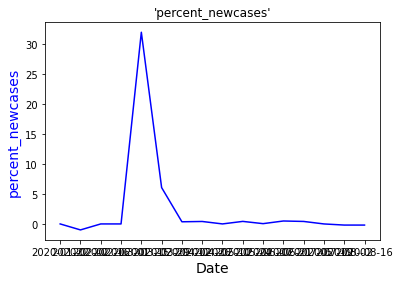

In [460]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [461]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.25000000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, -0.9166666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0

In [462]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Determining growth label

In [463]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

927


0.0

In [464]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  928


In [465]:
average_newCases_df2['growth_per_day'] = growth_values


### Checking mean, std dev and variance for growth data


In [466]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -377.00000000000006
max  377.00000000000006
mean  4.570662257598492e-05
std. deviation  20.151388621585387
variance  406.07846337816096


### Getting positive cases

In [467]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


length diffArr:  927
non_zero_pos_diff length:  351


In [468]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  0.0013773837468717964
max  377.00000000000006
mean  4.196743323399912
std. deviation  22.79037527125108
variance  519.4012050044528


### Getting negative cases

In [469]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  927
non_zero_neg_diff length :  343


In [470]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -377.00000000000006
max  -0.009978229317851839
mean  -4.29450302179079
std. deviation  23.01077232087632
variance  529.4956428032078


### Applying Jenks Natural break

In [471]:

pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.0013773837468717964, 157.48611111111111, 377.00000000000006]
[-377.00000000000006, -156.93522372528616, -0.009978229317851839]


#### **Note**: 

From the positive and negative break, 
* [ -0.009978 , 0.001377 ] - flat growth
* [ 0.001377 , 157.486111 ] - mild growth
* [ 157.486111 , 377.00 ] - drastic growth
* [ -0.009978 , -157.486111 ] - mild decrement
* [ -157.486111, -377.00 ] - drastic decrement

In [472]:
#original range for CA -inertia data
'''
def determine_growth_label_inertia(x):
  if x >= -0.009978 and x <= 0.001377:
    return 'flat_growth'
  if x > 0.001377 and x <= 157.486111:
    return 'mild_growth'
  if x > 157.486111 and x <= 377.00:
    return 'drastic_growth'
  if x >= -157.486111  and x <= -0.009978:
    return 'mild_decrement'
  if x >= -377.00 and x < -157.486111:
    return 'drastic_decrement'
'''

"\ndef determine_growth_label_inertia(x):\n  if x >= -0.009978 and x <= 0.001377:\n    return 'flat_growth'\n  if x > 0.001377 and x <= 157.486111:\n    return 'mild_growth'\n  if x > 157.486111 and x <= 377.00:\n    return 'drastic_growth'\n  if x >= -157.486111  and x <= -0.009978:\n    return 'mild_decrement'\n  if x >= -377.00 and x < -157.486111:\n    return 'drastic_decrement'\n"

In [473]:
# temporarily using same label range of combined data for inertia data

'''
def determine_growth_label_inertia(x):
  if x >= -0.012359 and x <= 0.000374:
    return 'flat_growth'
  if x > 0.000374 and x <= 21.813186:
    return 'mild_growth'
  if x > 21.813186 and x <= 95.421053:
    return 'drastic_growth'
  if x >= -21.813186  and x <= -0.012359:
    return 'mild_decrement'
  if x >= -95.421053 and x < -21.813186:
    return 'drastic_decrement'
'''

"\ndef determine_growth_label_inertia(x):\n  if x >= -0.012359 and x <= 0.000374:\n    return 'flat_growth'\n  if x > 0.000374 and x <= 21.813186:\n    return 'mild_growth'\n  if x > 21.813186 and x <= 95.421053:\n    return 'drastic_growth'\n  if x >= -21.813186  and x <= -0.012359:\n    return 'mild_decrement'\n  if x >= -95.421053 and x < -21.813186:\n    return 'drastic_decrement'\n"

In [474]:
# temporarily using NY combined data range for CA
def determine_growth_label_inertia(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [475]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )

In [476]:
average_newCases_df2.head(3)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth


In [477]:
average_newCases_df2_growth0 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_decrement']
average_newCases_df2_growth1 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_growth']
average_newCases_df2_growth2 = average_newCases_df2[average_newCases_df2['growth_label'] == 'flat_growth']
average_newCases_df2_growth3 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_decrement']
average_newCases_df2_growth4 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_growth']

print(average_newCases_df2_growth0.shape)
print(average_newCases_df2_growth1.shape)
print(average_newCases_df2_growth2.shape)
print(average_newCases_df2_growth3.shape)
print(average_newCases_df2_growth4.shape)

(5, 10)
(4, 10)
(234, 10)
(338, 10)
(347, 10)


## Jenks Natural breaks 

In [478]:
!pip install jenkspy


In [479]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.2, 44.0, 158.0, 377.00000000000006]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

4 class labeling

In [480]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.2, 13.882352941176471, 58.923076923076934, 158.0, 377.00000000000006]


In [481]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [482]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())

Number of records in LessSpread: 910
Number of records in Spread: 14
Number of records in SuperSpread: 2
Number of records in SuperSpread: 1


8 class labeling

In [483]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.2, 2.0497737556561093, 7.910256410256411, 21.000000000000004, 37.282051282051285, 58.923076923076934, 86.23809523809521, 158.0, 377.00000000000006]


In [484]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [485]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())

Number of records in LessSpread: 820
Number of records in Spread: 75
Number of records in SuperSpread: 19
Number of records in SuperSpread2: 8
Number of records in SuperSpread3: 2
Number of records in SuperSpread4: 1
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 1


In [486]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Alameda County,6001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Alpine County,6003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Amador County,6005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Butte County,6007,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Calaveras County,6009,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [487]:
CA_combined_sd_inertia_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [488]:
CA_combined_sd_inertia_data_ = CA_combined_sd_inertia_data.copy()

In [489]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [490]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    CA_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    CA_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']




928it [00:05, 165.65it/s]


In [491]:
CA_combined_sd_inertia_data.head(5)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
2,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
3,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
4,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth


In [492]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

Date                                          112
Province_State                                112
FIPS                                          112
New cases                                     112
mask_rule_active                              112
CTFIPS                                        112
CTNAME                                        112
STFIPS                                        112
Social distancing index                       112
% staying home                                112
Trips/person                                  112
% out-of-county trips                         112
% out-of-state trips                          112
Miles/person                                  112
Work trips/person                             112
Non-work trips/person                         112
New COVID cases                               112
Population                                    112
% change in consumption                       112
date                                          112


In [493]:
CA_combined_sd_inertia_data.shape

(12296, 56)

In [494]:
CA_combined_sd_inertia_data['label'] = CA_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

## Computing growth label per 1k population

In [495]:
newcases_1k_inertia = CA_combined_sd_inertia_data['New cases/1000 people'].values

In [496]:
diffArr = np.diff(newcases_1k_inertia)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

12295
growth_values :  1
growth_values :  12296


## Determining mean,stddev, variance

In [497]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)



min  -2.1359000000000004
max  2.1234
mean  2.1886945912973092e-05
std. deviation  0.1572441105161231
variance  0.024725710292006736


## Getting positive cases

In [498]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


length diffArr:  12295
non_zero_pos_diff length:  4474
min  9.99999999999994e-05
max  2.1234
mean  0.08838690210102815
std. deviation  0.16111661760534848
variance  0.025958564468588092


## Getting negative cases

In [499]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


non_zero_neg_diff length :  4501
min  -2.1359000000000004
max  -9.999999999998899e-05
mean  -0.08779691179737836
std. deviation  0.16206356923311943
variance  0.026264600472578094


## Applying natural breaks

In [510]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)


[9.99999999999994e-05, 0.3248, 2.1234]
[-2.1359000000000004, -0.34040000000000004, -9.999999999998899e-05]


## New Labeling

In [511]:

def determine_growth_label_inertia1k(x):
  if x >= -0.000009 and x <= 0.00009:
    return 'flat_growth'
  if x > 0.00009 and x <= 0.3248:
    return 'mild_growth'
  if x > 0.3248 and x <= 2.1234:
    return 'drastic_growth'
  if x >= -0.3404  and x <= -0.000009:
    return 'mild_decrement'
  if x >= -2.1359 and x < -0.3404:
    return 'drastic_decrement'

In [512]:
CA_combined_sd_inertia_data['growth_label_1k'] = CA_combined_sd_inertia_data['New cases/1000 people'].apply(lambda x: determine_growth_label_inertia1k(x) )

In [513]:
CA_combined_sd_inertia_data['growth_label_1k'].unique()
CA_combined_data['growth_label_1k'].unique()

array(['flat_growth', 'mild_growth', None, 'drastic_growth',
       'mild_decrement'], dtype=object)

In [514]:
CA_combined_sd_inertia_data_growth0 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_decrement']
CA_combined_sd_inertia_data_growth1 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_growth']
CA_combined_sd_inertia_data_growth2 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'flat_growth']
CA_combined_sd_inertia_data_growth3 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_decrement']
CA_combined_sd_inertia_data_growth4 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_growth']

print(CA_combined_sd_inertia_data_growth0.shape)
print(CA_combined_sd_inertia_data_growth1.shape)
print(CA_combined_sd_inertia_data_growth2.shape)
print(CA_combined_sd_inertia_data_growth3.shape)
print(CA_combined_sd_inertia_data_growth4.shape)


(70, 57)
(56, 57)
(3102, 57)
(4471, 57)
(4597, 57)


### Export Labeled Maryland Inertia Data

In [515]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_sd_inertia_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_sd_inertia_data.to_csv(location+filename,index=False)

CA_sd_inertia_labeledData_Sep25.csv


In [516]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels


## Kernal Density Estimation

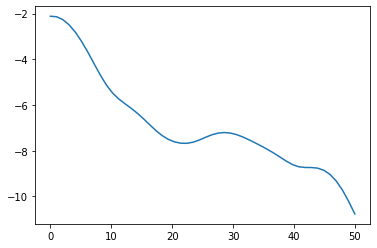

In [517]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [518]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [22.44897959]
Maxima: [28.57142857]


In [519]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

IndexError: ignored

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['growth_label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# unused code


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
week_df.head()

In [ ]:
CA_combined_data.dtypes

In [ ]:
start_date_df = (
    CA_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

In [ ]:
end_date_df = (
    CA_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)